In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
base_dir = "../data/processed"
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 20

print("Train:", len(train_dir))
print("Val:", len(val_dir))
print("Test:", len(test_dir))

Train: 23
Val: 21
Test: 22


In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 216 images belonging to 3 classes.
Found 48 images belonging to 3 classes.
Found 48 images belonging to 3 classes.


In [4]:
labels = train_generator.classes

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(class_weights))
class_weights


{0: 0.782608695652174, 1: 1.1612903225806452, 2: 1.1612903225806452}

In [5]:
model = Sequential([
  
    Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax")
])

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)      

In [6]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [7]:
base_dir = os.path.dirname(os.getcwd())
model_dir = os.path.join(base_dir, "models")
os.makedirs(model_dir, exist_ok=True)

checkpoint = ModelCheckpoint(
    os.path.join(model_dir, "best_cnn.h5"),
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=2,
    verbose=1
)

callbacks = [checkpoint, early_stop, reduce_lr]


In [8]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/20


14/14 [==============================] - ETA: 0s - loss: 1.0926 - accuracy: 0.3241
Epoch 1: val_loss improved from inf to 1.04525, saving model to C:\Users\Mounika\models\best_cnn.h5
14/14 [==============================] - 35s 2s/step - loss: 1.0926 - accuracy: 0.3241 - val_loss: 1.0453 - val_accuracy: 0.7292 - lr: 1.0000e-04
Epoch 2/20
14/14 [==============================] - ETA: 0s - loss: 1.0326 - accuracy: 0.5324
Epoch 2: val_loss improved from 1.04525 to 0.98822, saving model to C:\Users\Mounika\models\best_cnn.h5
14/14 [==============================] - 27s 2s/step - loss: 1.0326 - accuracy: 0.5324 - val_loss: 0.9882 - val_accuracy: 0.5625 - lr: 1.0000e-04
Epoch 3/20
14/14 [==============================] - ETA: 0s - loss: 0.9292 - accuracy: 0.5880
Epoch 3: val_loss improved from 0.98822 to 0.74104, saving model to C:\Users\Mounika\models\best_cnn.h5
14/14 [==============================] - 29s 2s/step - loss: 0.9292 - accuracy: 0.5880 - val_loss: 0.7410 - val_accu

In [9]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)


3/3 [==============================] - 3s 943ms/step - loss: 0.2885 - accuracy: 0.8958
Test Accuracy: 0.8958333134651184


3/3 [==============================] - 3s 836ms/step


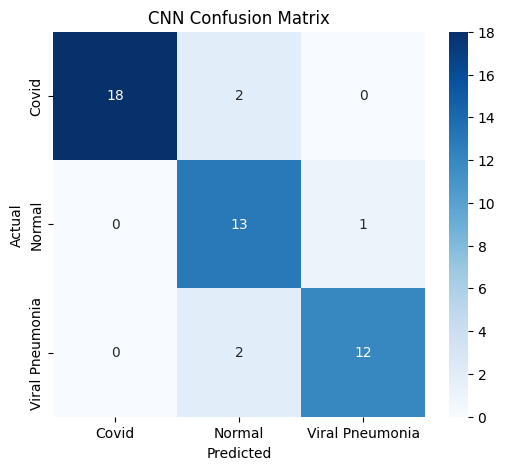

                 precision    recall  f1-score   support

          Covid       1.00      0.90      0.95        20
         Normal       0.76      0.93      0.84        14
Viral Pneumonia       0.92      0.86      0.89        14

       accuracy                           0.90        48
      macro avg       0.90      0.90      0.89        48
   weighted avg       0.91      0.90      0.90        48



In [10]:
pred_probs = model.predict(test_generator)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = test_generator.classes

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=test_generator.class_indices.keys(),
    yticklabels=test_generator.class_indices.keys()
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("CNN Confusion Matrix")
plt.show()

print(classification_report(
    true_labels,
    pred_labels,
    target_names=test_generator.class_indices.keys()
))


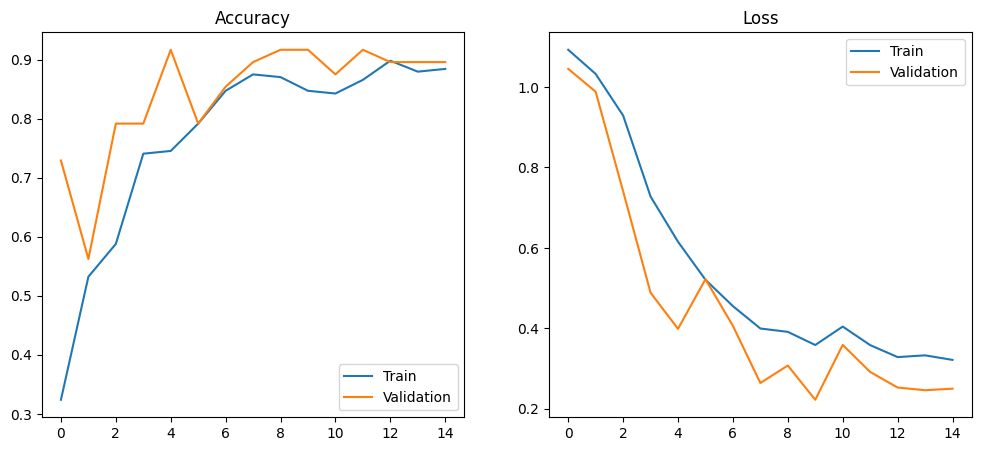

In [11]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Loss")
plt.legend()

plt.show()


In [12]:
model.save(os.path.join(model_dir, "final_cnn.h5"))
print("CNN model saved successfully!")


CNN model saved successfully!
